In [ ]:
import pandas as pd, matplotlib.pyplot as plt, geopandas as gpd, numpy as np
import folium
from folium import plugins

# Abrimos archivos

radios = gpd.read_file(r"C:\Users\user\Downloads\METODOLOGÍA\MET4OP\dataset\censo2010\radios_censales\Codgeo_CABA_con_datos\cabaxrdatos.shp")
caba_shape = gpd.read_file(r"C:\Users\user\Downloads\METODOLOGÍA\MET4OP\dataset\elecciones_2019\CABA.shp")
radios.to_crs(caba_shape.crs, inplace=True) # para que se complementen bien los mapas
elecciones_raw = pd.read_csv('https://raw.githubusercontent.com/MET4OP-UBA/MET4OP/master/dataset/elecciones_2019/resultados/120819-054029/datos_agrup.csv')

In [4]:
# Ordenamos elecciones_raw para despues mergear correctamente

elecciones = elecciones_raw[['CODIGO_CIRCUITO', 'CODIGO_MESA','NOMBRE_REGION', "VOTOS_AGRUPACION", "NOMBRE_CATEGORIA", "NOMBRE_AGRUPACION"]] # Seleccionamos columnas que nos sirven

elecciones = elecciones[elecciones["NOMBRE_CATEGORIA"]== 'Presidente y Vicepresidente de la República'] # seleccionamos solo categoria presidencial para analizar
elecciones = elecciones.rename(columns={'NOMBRE_REGION': 'COMUNAS'}) # renombramos columna para futuro merge

elecciones['COMUNAS'] = elecciones['COMUNAS'].apply(str) # convertimos a string para poder hacer slicing
elecciones['COMUNAS'] = elecciones['COMUNAS'].str[-2:] # seleccionamos ultimos dos digitos que son los de la comuna para mas facil visualizacion y mergeo posterior con rossetta?
elecciones['COMUNAS'] = elecciones['COMUNAS'].apply(int)

elecciones['CODIGO_CIRCUITO'] = elecciones['CODIGO_CIRCUITO'].apply(str) # convertimos a string para poder hacer slicing
elecciones['CODIGO_CIRCUITO'] = elecciones['CODIGO_CIRCUITO'].str[-3:] # seleccionamos ultimos tres digitos que son los de la comuna para mas facil visualizacion y mergeo posterior con rossetta?
elecciones['CODIGO_CIRCUITO'] = elecciones['CODIGO_CIRCUITO'].apply(int)

# Ordenamos caba_shape para despues mergear correctamente

caba_shape = caba_shape.rename(columns={'circuito': "CODIGO_CIRCUITO", 'departamen': 'COMUNAS'}) # renombramos columnas para futuro merge

caba_shape = caba_shape[['CODIGO_CIRCUITO', 'COMUNAS', 'geometry']] # seleccionamos columnas que nos sirven

caba_shape['CODIGO_CIRCUITO'] = caba_shape['CODIGO_CIRCUITO'].apply(str) # convertimos a string para poder hacer slicing
caba_shape['CODIGO_CIRCUITO'] = caba_shape['CODIGO_CIRCUITO'].str[-3:] # seleccionamos ultimos 3 digitos que son los del circuito
caba_shape['CODIGO_CIRCUITO'] = caba_shape['CODIGO_CIRCUITO'].apply(int)

Votos_por_comuna = elecciones.groupby(['NOMBRE_AGRUPACION','COMUNAS'])[['VOTOS_AGRUPACION']].sum()  # Agrupamos los votos por comuna
Votos_por_circuito = elecciones.groupby(['NOMBRE_AGRUPACION','COMUNAS','CODIGO_CIRCUITO'])[['VOTOS_AGRUPACION']].sum()  # Agrupamos los votos por circuito
TablaComuna = Votos_por_comuna.drop(["RECURRIDO","IMPUGNADO", "NULO", "BLANCO"]) # Eliminamos las categorías que no nos sirven para calcular los %
TablaCircuito = Votos_por_circuito.drop(["RECURRIDO","IMPUGNADO", "NULO", "BLANCO"])

# Pivoteamos tablas para que queden mejor ordenadas

Tabla_Comunas = pd.pivot_table(TablaComuna, values=None, index="NOMBRE_AGRUPACION", columns='COMUNAS', aggfunc='mean',
                                fill_value=None, margins=False, dropna=True, margins_name='All', observed=False, sort=True) # Pivoteo las tablas para que queden más ordenadas
Tabla_Circuito= pd.pivot_table(TablaCircuito, values=None, index="NOMBRE_AGRUPACION", columns='CODIGO_CIRCUITO', aggfunc='mean', 
                                fill_value=None, margins=False, dropna=True, margins_name='All', observed=False, sort=True) #Pivoteo las tablas para que queden más ordenadas
 
Porcentaje_JxC_Comunas = Tabla_Comunas/Tabla_Comunas[Tabla_Comunas.columns].sum()*100 # Calculamos porcentaje de los partidos por comuna
Porcentaje_JxC_Comunas = Porcentaje_JxC_Comunas.round(2) # Redondeamos
Porcentaje_JxC_Comunas = Porcentaje_JxC_Comunas.drop(["CONSENSO FEDERAL",'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD','FRENTE DE TODOS','FRENTE NOS','FRENTE PATRIOTA','MOVIMIENTO AL SOCIALISMO',
                                                        'MOVIMIENTO DE ACCION VECINAL','PARTIDO AUTONOMISTA','UNITE POR LA LIBERTAD Y LA DIGNIDAD']) #Elimino los partidos que no me interesan

Porcentaje_JxC_Circuito = Tabla_Circuito/Tabla_Circuito[Tabla_Circuito.columns].sum()*100 # Calculamos porcentaje de los partidos por circuito
Porcentaje_JxC_Circuito = Porcentaje_JxC_Circuito.round(2) # Redondeamos
Porcentaje_JxC_Circuito = Porcentaje_JxC_Circuito.drop(["CONSENSO FEDERAL",'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD','FRENTE DE TODOS','FRENTE NOS','FRENTE PATRIOTA','MOVIMIENTO AL SOCIALISMO',
                                        'MOVIMIENTO DE ACCION VECINAL','PARTIDO AUTONOMISTA','UNITE POR LA LIBERTAD Y LA DIGNIDAD']) #Elimino los partidos que no me interesan


Porcentaje_JxC_Circuito = Porcentaje_JxC_Circuito.transpose() # Invertimos filas x columnas
Caba_Shape_= pd.merge(caba_shape, Porcentaje_JxC_Circuito, on="CODIGO_CIRCUITO", how="inner") # Hacemos merge para tener la geometría 

Caba_Shape_['COMUNAS'] = Caba_Shape_['COMUNAS'].apply(str) # convertimos a string para poder hacer slicing
Caba_Shape_['COMUNAS'] = Caba_Shape_['COMUNAS'].str[-2:] # seleccionamos ultimos 3 digitos que son los de las comunas para mapear despues por comuna
Caba_Shape_['COMUNAS'] = Caba_Shape_['COMUNAS'].apply(int)

Caba_Shape_= Caba_Shape_.set_geometry('geometry') # Seteamos geometria
Caba_Shape_ = Caba_Shape_.sort_values(by= 'CODIGO_CIRCUITO') # Ordenamos por circuito 

Caba_Shape_ # Geometria de los circuitos y como le fue a JxC en cada circuito

,CODIGO_CIRCUITO,COMUNAS,geometry,JUNTOS POR EL CAMBIO
7,1,1,"POLYGON Z ((-6497294.216 -4088142.493 0.000, -...",38.37
8,2,1,"POLYGON Z ((-6498537.655 -4087740.684 0.000, -...",35.84
0,3,1,"POLYGON Z ((-6496304.252 -4084732.697 0.000, -...",74.24
5,5,1,MULTIPOLYGON Z (((-6497185.903 -4082052.692 0....,17.64
16,6,1,"POLYGON Z ((-6499644.727 -4084669.159 0.000, -...",77.99
...,...,...,...,...
160,163,15,"POLYGON Z ((-6505348.070 -4083866.211 0.000, -...",36.20
156,164,15,"POLYGON Z ((-6507652.050 -4084945.661 0.000, -...",39.55
151,165,15,"POLYGON Z ((-6508638.340 -4081745.040 0.000, -...",44.13
152,166,15,"POLYGON Z ((-6508941.686 -4083702.129 0.000, -...",40.99


In [5]:
radios_censales = radios[['VARONES', 'MUJERES', 'TOT_POB', 'geometry']]  # recortamos a columnas que nos sirven

radios_censales

,VARONES,MUJERES,TOT_POB,geometry
0,312.0,342.0,654.0,"POLYGON ((-6508495.397 -4076757.869, -6508533...."
1,296.0,272.0,568.0,"POLYGON ((-6507589.408 -4076935.049, -6507567...."
2,379.0,384.0,763.0,"POLYGON ((-6508678.933 -4076687.905, -6508559...."
3,286.0,326.0,612.0,"POLYGON ((-6508678.933 -4076687.905, -6508671...."
4,373.0,397.0,770.0,"POLYGON ((-6508853.232 -4076907.578, -6508854...."
...,...,...,...,...
3550,461.0,543.0,1004.0,"POLYGON ((-6509092.003 -4097339.498, -6508976...."
3551,330.0,442.0,772.0,"POLYGON ((-6509614.432 -4097372.317, -6509478...."
3552,475.0,503.0,978.0,"POLYGON ((-6508828.370 -4097582.078, -6508695...."
3553,427.0,488.0,915.0,"POLYGON ((-6509345.896 -4097618.481, -6509214...."


In [6]:
import geopandas as gpd 

# Spatial Join de ambas geometrias

felicidad = gpd.sjoin(radios_censales, Caba_Shape_, how="right", predicate='intersects')

felicidad['TOT_POB'] = felicidad.groupby(['CODIGO_CIRCUITO'])['TOT_POB'].transform('sum') # Calculamos y agrupamos el total de la poblacion por circuito para despues poder calcular porcentaje
felicidad['VARONES'] = felicidad.groupby(['CODIGO_CIRCUITO'])['VARONES'].transform('sum') # Calculamos y agrupamos el total de los varones por circuito para despues poder calcular porcentaje
felicidad['MUJERES'] = felicidad.groupby(['CODIGO_CIRCUITO'])['MUJERES'].transform('sum') # Calculamos y agrupamos el total de las mujeres por circuito para despues poder calcular porcentaje
felicidad['%VARONES'] = (felicidad['VARONES']/felicidad['TOT_POB'])*100 # Calculamos el porcentaje de varones en la poblacion para despues graficar correlacion con % votos
felicidad['%VARONES'] = felicidad['%VARONES'].round(2) # Redondeamos 
felicidad['%MUJERES'] = (felicidad['MUJERES']/felicidad['TOT_POB'])*100 # Calculamos el porcentaje de mujeres en la poblacion para despues graficar correlacion con % votos
felicidad['%MUJERES'] = felicidad['%MUJERES'].round(2) # Redondeamos
#
#  Renombramos para visualizar mas prolijo despues
felicidad = felicidad.rename(columns={'JUNTOS POR EL CAMBIO': '% Votos de JxC', 'CODIGO_CIRCUITO' : 'Circuito', '%VARONES': '% Varones', '%MUJERES': '% Mujeres'}) 

felicidad1 = felicidad[['Circuito', '% Varones', '% Mujeres', '% Votos de JxC', 'geometry']] # Recortamos a columnas que nos sirven

felicidad1 = felicidad1.dissolve(by= 'Circuito') # Ordenamos y agrupamos por circuito para mas prolijidad

felicidad1

,geometry,% Varones,% Mujeres,% Votos de JxC
Circuito,,,,
1,"POLYGON Z ((-6497215.291 -4088619.054 0.000, -...",46.78,53.22,38.37
2,"POLYGON Z ((-6498066.328 -4087549.480 0.000, -...",48.09,51.91,35.84
3,"POLYGON Z ((-6496257.387 -4084750.332 0.000, -...",54.03,45.97,74.24
5,MULTIPOLYGON Z (((-6498813.171 -4082720.648 0....,50.96,49.04,17.64
6,"POLYGON Z ((-6499715.749 -4084266.533 0.000, -...",43.76,56.24,77.99
...,...,...,...,...
163,"POLYGON Z ((-6505372.561 -4083880.479 0.000, -...",47.38,52.62,36.20
164,"POLYGON Z ((-6508347.240 -4084936.372 0.000, -...",46.91,53.09,39.55
165,"POLYGON Z ((-6507763.035 -4082470.311 0.000, -...",46.90,53.10,44.13


Text(0.5, 1.0, 'Relación % votos de JxC y % varones por circuito')

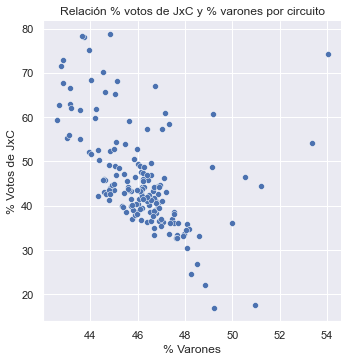

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Relplot varones

sns.set(style = 'darkgrid')

sns.relplot(x = '% Varones', y = '% Votos de JxC', data= felicidad1)
plt.title("Relación % votos de JxC y % varones por circuito")

Text(0.5, 1.0, 'Relación % votos de JxC y % mujeres por circuito')

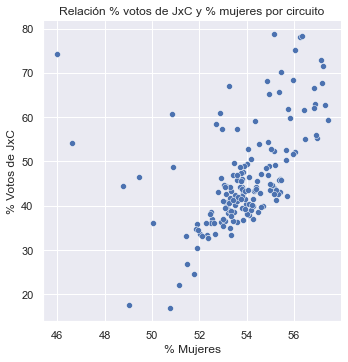

In [8]:
# Relplot mujeres

sns.set(style = 'darkgrid')

sns.relplot(x = '% Mujeres', y = '% Votos de JxC', data= felicidad1)
plt.title("Relación % votos de JxC y % mujeres por circuito")

Estos gráficos muestran a las claras una correlación entre el género femenino y masculino y la cantidad de votos obtenidos por JxC. Mientras el porcentaje de hombres aumenta, disminuye la cantidad de votos obtenidos por JxC e inversamente mientras el porcentaje de mujeres aumenta también aumenta el porcentaje de votos obtenidos por dicha fuerza política. 

In [9]:
#Armo un primer mapa: minteractivo_circuitos para poder observar más fácilmente las diferencias entre circuitos situandome con el mouse
#En cada uno de ellos

minteractivo_circuitos = felicidad1.explore(
     column="% Votos de JxC",  # hago mapa tipo choropleth basado en la columna % Votos de JxC
     scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
     legend=True, 
     k=10,
     tiles= "CartoDB positron",
     cmap='BuPu', 
     legend_kwds=dict(colorbar=False) 
)
minteractivo_circuitos

En este gráfico podemos observar que el peor desempeño de JxC se da en el circuito 5 ubicado en Retiro. Obtuvo el 17% de los votos. La otra particularidad que nos permite inferir una relación entre género y votos es que es uno de los pocos circuitos donde la cantidad de hombres es superior a la cantidad de mujeres. 

Text(0.5, 1.0, '% JxC por Circuito')

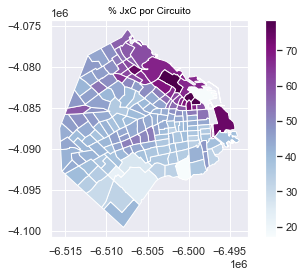

In [10]:
# Segundo mapa: Mapa_JxC_Circuitos: circuitos electorales y porcentaje de votos de JxC en cada uno de ellos

felicidad1.set_geometry('geometry')
fig, ax = plt.subplots(1, 1)
Mapa_JxC_Circuitos = felicidad1.plot(column='% Votos de JxC', 
                ax=ax, 
                figsize=(30, 30),
                cmap='BuPu', 
                legend={'label': "Porcentajes Juntos Por El Cambio", 'orientation': "horizontal"})
plt.title("% JxC por Circuito", fontsize=10, color="Black")

Text(0.5, 1.0, '% Varones por Circuito')

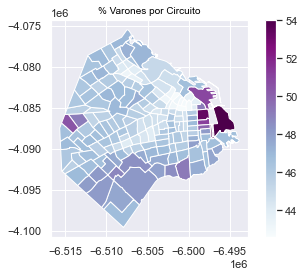

In [11]:
# Tercer mapa: Mapa_JxC_Circuitos: circuitos electorales y porcentaje de varones en cada uno de ellos

felicidad1.set_geometry('geometry')
fig, ax = plt.subplots(1, 1)
Mapa_JxC_Circuitos = felicidad1.plot(column='% Varones', 
                ax=ax, 
                figsize=(30, 30),
                cmap='BuPu', 
                legend={'label': "Porcentajes Varones", 'orientation': "horizontal"})
plt.title("% Varones por Circuito", fontsize=10, color="Black")

Text(0.5, 1.0, '% Mujeres por Circuito')

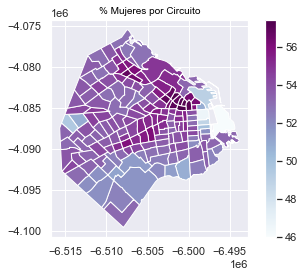

In [12]:
# Cuarto mapa: Mapa_Mujeres_Circuitos: Porcentaje Mujeres por circuito electoral

fig, ax = plt.subplots(1, 1)
Mapa_Mujeres_Circuitos = felicidad1.plot(column='% Mujeres', 
                ax=ax, 
                figsize=(30, 30),
                cmap='BuPu', 
                legend={'label': "Porcentajes Mujeres por Circuito", 'orientation': "horizontal"})
plt.title("% Mujeres por Circuito", fontsize=10, color="Black")

Text(0.5, 1.0, 'Diferencia entre Varones y Mujeres por Circuito')

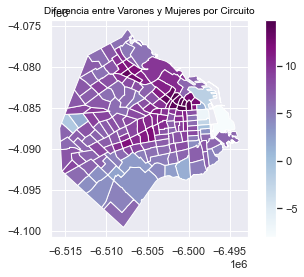

In [13]:
# Calculamos la diferencia entre % de varones y mujeres por circuito y armamos una nueva columna.
felicidad1['Diferencia entre % V y M'] = felicidad1['% Mujeres'] - felicidad1['% Varones']
dif_vym = felicidad1

# Ahora armamos un quinto mapa para graficar la diferencia. 
fig, ax = plt.subplots(1, 1)
Mapa_Diferencia_VyM = dif_vym.plot(column='Diferencia entre % V y M', 
                ax=ax, 
                figsize=(30, 30),
                cmap='BuPu', 
                legend={'label': "Diferencia entre Varones y Mujeres por Circuito", 'orientation': "horizontal"})
plt.title("Diferencia entre Varones y Mujeres por Circuito", fontsize=10, color="Black")

In [14]:
import geopandas as gpd

# Armamos una nueva tabla para poder plotear Comunas


# Reordenamos la tabla para poder hacer mas adelante un append manual a la variable felicidad2 y poder graficar por comuna

Porcentaje_JxC_Comunas = Porcentaje_JxC_Comunas.transpose() # Invertimos filas x columnas

# Spatial Join de ambas geometrias

felicidad2 = gpd.sjoin(radios_censales, Caba_Shape_, how="right", predicate='intersects') 
felicidad2['TOT_POB'] = felicidad2.groupby(['COMUNAS'])['TOT_POB'].transform('sum') # Calculamos y agrupamos el total de la poblacion por comuna para despues poder calcular porcentaje
felicidad2['VARONES'] = felicidad2.groupby(['COMUNAS'])['VARONES'].transform('sum') # Calculamos y agrupamos el total de los varones por comuna para despues poder calcular porcentaje
felicidad2['MUJERES'] = felicidad2.groupby(['COMUNAS'])['MUJERES'].transform('sum') # Calculamos y agrupamos el total de las mujeres por comuna para despues poder calcular porcentaje
felicidad2['%VARONES'] = (felicidad2['VARONES']/felicidad2['TOT_POB'])*100 # Calculamos el porcentaje de varones en la poblacion para despues graficar correlacion con % votos
felicidad2['%VARONES'] = felicidad2['%VARONES'].round(2) # Redondeamos 
felicidad2['%MUJERES'] = (felicidad2['MUJERES']/felicidad2['TOT_POB'])*100 # Calculamos el porcentaje de mujeres en la poblacion para despues graficar correlacion con % votos
felicidad2['%MUJERES'] = felicidad2['%MUJERES'].round(2) # Redondeamos
# #
# #  Renombramos para visualizar mas prolijo despues
felicidad2 = felicidad2.rename(columns={'JUNTOS POR EL CAMBIO': '% Votos de JxC', '%VARONES': '% Varones', '%MUJERES': '% Mujeres'}) 

felicidad2 = felicidad2[['COMUNAS', '% Varones', '% Mujeres', '% Votos de JxC', 'geometry']] # Recortamos a columnas que nos sirven

felicidad2 = felicidad2.dissolve(by= 'COMUNAS') # Ordenamos y agrupamos por circuito para mas prolijidad

extension = Porcentaje_JxC_Comunas["JUNTOS POR EL CAMBIO"] # De la tabla de Comunas hacemos un append manual para tener el porcentaje de votos por comunas
felicidad2 = felicidad2.join(extension)

felicidad2= felicidad2.drop(['% Votos de JxC'], axis=1) # Dropeamos los votos de JxC por circuito
felicidad2 = felicidad2.reset_index() # Reseteaoms index 
felicidad2 = felicidad2.drop(['level_0'], axis=1) # Dropeamos columna que se sumo cuando hicimos el append manual 

felicidad2

,COMUNAS,geometry,% Varones,% Mujeres,JUNTOS POR EL CAMBIO
0,1,MULTIPOLYGON Z (((-6500163.365 -4086625.552 0....,47.76,52.24,46.53
1,2,"POLYGON Z ((-6502839.597 -4085102.896 0.000, -...",43.20,56.80,64.88
2,3,"POLYGON Z ((-6502626.420 -4086456.447 0.000, -...",45.53,54.47,41.51
3,4,"POLYGON Z ((-6503717.796 -4093736.476 0.000, -...",47.30,52.70,36.41
4,5,"POLYGON Z ((-6502442.965 -4088336.670 0.000, -...",45.25,54.75,41.47
5,6,"POLYGON Z ((-6507360.949 -4088085.264 0.000, -...",44.76,55.24,47.76
6,7,"POLYGON Z ((-6509719.698 -4088406.154 0.000, -...",46.48,53.52,41.58
7,8,"POLYGON Z ((-6512172.623 -4095226.096 0.000, -...",47.86,52.14,31.23
8,9,"POLYGON Z ((-6515446.195 -4092612.119 0.000, -...",47.14,52.86,38.12
9,10,"POLYGON Z ((-6513681.670 -4089920.376 0.000, -...",46.43,53.57,41.56


In [15]:
# Sexto mapa: minteractivo_comunas para tener una primer visión más fácil del mapa y sus valores
minteractivo_comunas = felicidad2.explore(
     column="JUNTOS POR EL CAMBIO",  # hago mapa tipo choropleth basado en la columna JUNTOS POR EL CAMBIO
     scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
     legend=True, 
     k=10,
     tiles= "CartoDB positron",
     cmap='BuPu', 
     legend_kwds=dict(colorbar=False), 
)
minteractivo_comunas

Lo mismo se observa a nivel comunas: por un lado observamos que el peor desempeño de JxC se da justamente en la comuna donde la diferencia porcentual entre hombres y mujeres es la más baja (la comuna 8 con una diferencia entre los géneros de 4,28% y JxC obtuvo el 31%  de los sufragios) mientras que el mejor desempeño de JxC se da en la comuna donde la diferencia entre hombres y mujeres es la más amplia: La comuna 2 donde la brecha es casi del 14% y JxC obtuvo casi el 65% de los votos. 

Text(0.5, 1.0, '% JxC por Comuna')

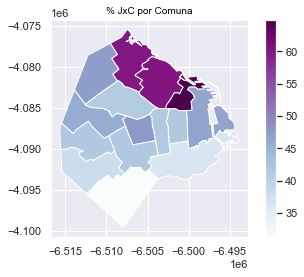

In [16]:
# Septimo mapa: Mapa_JxC_Comunas: Porcentaje de votos de JxC por Comunas

felicidad2.set_geometry('geometry')
fig, ax = plt.subplots(1, 1)
Mapa_JxC_Comunas = felicidad2.plot(column='JUNTOS POR EL CAMBIO', 
                ax=ax, 
                figsize=(30, 30),
                cmap='BuPu', 
                legend={'label': "Porcentajes Juntos Por El Cambio por Comuna", 'orientation': "horizontal"})
plt.title("% JxC por Comuna", fontsize=10, color="Black")

Text(0.5, 1.0, '% Varones por Comuna')

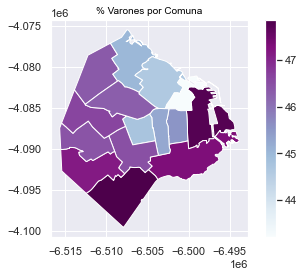

In [17]:
#Octavo mapa: Mapa_Varones_Comunas: Porcentaje de Varones por comunas

felicidad2.set_geometry('geometry')
fig, ax = plt.subplots(1, 1)
Mapa_Varones_Comunas = felicidad2.plot(column='% Varones', 
                ax=ax, 
                figsize=(30, 30),
                cmap='BuPu', 
                legend={'label': "Porcentajes Varones por Comuna", 'orientation': "horizontal"})
plt.title("% Varones por Comuna", fontsize=10, color="Black")

Text(0.5, 1.0, '% Mujeres por Comuna')

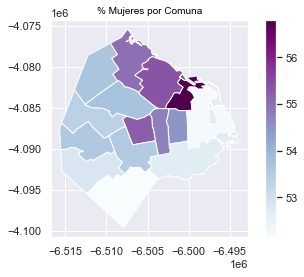

In [18]:
#Noveno mapa: Mapa_Mujeres_Comunas: Porcentaje de Mujeres por comunas

fig, ax = plt.subplots(1, 1)
Mapa_Mujeres_Comunas = felicidad2.plot(column='% Mujeres', 
                ax=ax, 
                figsize=(30, 30),
                cmap='BuPu', 
                legend={'label': "Porcentajes Mujeres por Comuna", 'orientation': "horizontal"})
plt.title("% Mujeres por Comuna", fontsize=10, color="Black")

Text(0.5, 1.0, 'Diferencia entre Varones y Mujeres por Comuna')

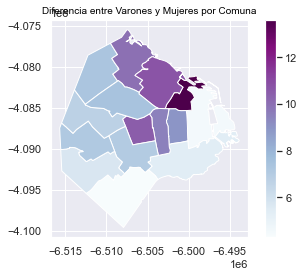

In [19]:
#Calculamos la diferencia entre % de varones y mujeres por comuna y armamos una nueva columna.

felicidad2['Diferencia entre % V y M'] = felicidad2['% Mujeres'] - felicidad2['% Varones']
dif_vym_comuna = felicidad2

# #Ahora armamos un décimo mapa para graficar la diferencia. 
fig, ax = plt.subplots(1, 1)
Mapa_Diferencia_VyM = dif_vym_comuna.plot(column='Diferencia entre % V y M', 
                ax=ax, 
                figsize=(30, 30),
                cmap='BuPu', 
                legend={'label': "Diferencia entre Varones y Mujeres por Comuna", 'orientation': "horizontal"})
plt.title("Diferencia entre Varones y Mujeres por Comuna", fontsize=10, color="Black")

In [20]:
# Armamos correlación en Circuitos

felicidad1 = felicidad1.reset_index()
correlacion_circuito_M= felicidad1.drop(['Circuito', 'geometry', '% Varones', 'Diferencia entre % V y M'], axis=1)
correlacion_circuito_H = felicidad1.drop(['Circuito', 'geometry', '% Mujeres', 'Diferencia entre % V y M'], axis=1)
print(correlacion_circuito_H.corr('spearman'))
print(correlacion_circuito_M.corr('spearman'))

                % Varones  % Votos de JxC
% Varones        1.000000       -0.603937
% Votos de JxC  -0.603937        1.000000
                % Mujeres  % Votos de JxC
% Mujeres        1.000000        0.603937
% Votos de JxC   0.603937        1.000000


In [21]:
#Armamos correlación en Comunas

Corr_M = felicidad2.drop(['COMUNAS', 'geometry', '% Varones', 'Diferencia entre % V y M'], axis=1)
Corr_H = felicidad2.drop(['COMUNAS', 'geometry', '% Mujeres', 'Diferencia entre % V y M'], axis=1)

print(Corr_M.corr('spearman'))
print(Corr_H.corr('spearman'))

                      % Mujeres  JUNTOS POR EL CAMBIO
% Mujeres              1.000000              0.689286
JUNTOS POR EL CAMBIO   0.689286              1.000000
                      % Varones  JUNTOS POR EL CAMBIO
% Varones              1.000000             -0.689286
JUNTOS POR EL CAMBIO  -0.689286              1.000000


In [22]:
######### LIMPIEZA DE DATOS DE CENSO Y CORROBORACION DE CANTIDAD DE POBLACION

# Agrupamos por radio el total de la poblacion para corroborar que esta tabla y P02 tienen los mismos datos

import pandas as pd

PoblacionTotal_RADIO = radios.groupby(['RADIO']).agg({'TOT_POB':'sum'})                 #Agrupo por COMUNA

 
Pob_M_RADIO= radios.groupby(['RADIO']).agg({'MUJERES':'sum'}) #Agrupo Mujeres


Pob_V_RADIO= radios.groupby(['RADIO']).agg({'VARONES':'sum'}) #Agrupo Hombres

PoblacionTotal_RADIO = pd.merge(PoblacionTotal_RADIO,Pob_M_RADIO, on="RADIO", how="inner") #Mergeo las tablas para tener una sola con el total. Hay que ver por qué la columna geometry desaparece. No sirve tenerlo por comuna, mejor tenerlo por circuito pero no está en el radio. 
PoblacionTotal_RADIO = pd.merge(PoblacionTotal_RADIO,Pob_V_RADIO, on="RADIO", how="inner")

PoblacionTotal_RADIO['TOTAL'] = PoblacionTotal_RADIO['TOT_POB'].sum()

PoblacionTotal_RADIO

,TOT_POB,MUJERES,VARONES,TOTAL
RADIO,,,,
01,290018.0,156057.0,133961.0,2890151.0
02,289614.0,156747.0,132867.0,2890151.0
03,286542.0,155412.0,131130.0,2890151.0
04,283713.0,153682.0,130031.0,2890151.0
05,278792.0,151149.0,127643.0,2890151.0
06,281564.0,152166.0,129398.0,2890151.0
07,269683.0,146165.0,123518.0,2890151.0
08,257244.0,138995.0,118249.0,2890151.0
09,231258.0,124654.0,106604.0,2890151.0


In [23]:
# Abrimos los archivos del censo

import pandas as pd

dpto_csv = pd.read_csv(r'C:\Users\user\Downloads\METODOLOGÍA\MET4OP\dataset\censo2010\dpto.csv')
frac_csv = pd.read_csv(r'C:\Users\user\Downloads\METODOLOGÍA\MET4OP\dataset\censo2010\frac.csv')
hogar_csv = pd.read_csv(r'C:\Users\user\Downloads\METODOLOGÍA\MET4OP\dataset\censo2010\hogar.csv')
persona_csv = pd.read_csv(r'C:\Users\user\Downloads\METODOLOGÍA\MET4OP\dataset\censo2010\persona.csv')
prov_csv = pd.read_csv(r'C:\Users\user\Downloads\METODOLOGÍA\MET4OP\dataset\censo2010\prov.csv')
radio_csv = pd.read_csv(r'C:\Users\user\Downloads\METODOLOGÍA\MET4OP\dataset\censo2010\radio.csv')
vivienda_csv = pd.read_csv(r'C:\Users\user\Downloads\METODOLOGÍA\MET4OP\dataset\censo2010\vivienda.csv') 

In [24]:
# Juntamos todas las tablas y armamos tablas del censo

dep_frac = dpto_csv.merge(frac_csv, on=['DPTO_REF_ID'], how='inner')      
dep_frac_rad = dep_frac.merge(radio_csv, on=['FRAC_REF_ID'], how='inner')
dep_frac_rad_viv = dep_frac_rad.merge(vivienda_csv, on=['RADIO_REF_ID'], how='inner')
dep_frac_rad_viv_hog = dep_frac_rad_viv.merge(hogar_csv, on=['VIVIENDA_REF_ID'], how='inner')
dep_frac_rad_viv_hog_per = dep_frac_rad_viv_hog.merge(persona_csv, on=['HOGAR_REF_ID'], how='inner')
tabla_censo = dep_frac_rad_viv_hog_per 
tabla_censo.reset_index

# Renombramos columnas
tabla_censo.rename(columns={'P02': 'SEXO', 'P03': 'EDAD', 'IDDPTO':'COMUNA','RADIO_REF_ID':'RADIO', 'IDFRAC':'FRAC'},inplace=True)

In [25]:
# Desagregamos variable P02 (de persona.csv) del censo que contiene solo valores 1 (varones) y 2 (mujeres)

varones = tabla_censo.loc[(tabla_censo["SEXO"] == 1)] # Creamos variable a partir de los valores 1 (varones)

varones.rename(columns={'SEXO': 'VARON'},inplace=True) # Renombramos columna

Varones_Radio = varones.groupby(['RADIO'])[['VARON']].sum() # Groupby por radio y calculamos cantidad varones por idradio

mujeres = tabla_censo.loc[(tabla_censo["SEXO"] == 2)] # Creamos variable a partir de los valores 2 (mujeres)

mujeres.rename(columns={'SEXO': 'MUJER'},inplace=True) # Renombramos columnas

mujeres_Radio = mujeres.groupby(['RADIO'])[['MUJER']].sum()/2 # Como el valor de mujeres era 2 dividimos por 2 

mujeres1 = mujeres_Radio["MUJER"] 
Sexo_Radio = Varones_Radio.join(mujeres1)

Sexo_Radio['Total_Varon'] = Sexo_Radio['VARON'].sum() # Total varones
Sexo_Radio['Total_Mujer'] = Sexo_Radio['MUJER'].sum() # Total mujeres
Sexo_Radio

C:\Users\user\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,VARON,MUJER,Total_Varon,Total_Mujer
RADIO,,,,
1,212,124.0,1329681,1560470.0
2,232,246.0,1329681,1560470.0
3,188,213.0,1329681,1560470.0
4,170,167.0,1329681,1560470.0
5,297,305.0,1329681,1560470.0
...,...,...,...,...
3549,390,473.0,1329681,1560470.0
3550,269,344.0,1329681,1560470.0
3551,339,358.0,1329681,1560470.0


In [26]:
print("Poblacion Total:", 1329681+1560470) # Chequeamos que la poblacion total es la misma que la del shape de radios

Poblacion Total: 2890151
